In [1]:
import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from collections import deque


# General settings
seed = 42
# image_file = "sample_map.png"

# Task 1 - Occupancy map
unsafe_kernel_size = 5
unsafe_iterations = 5

In [2]:
class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id,x,y)
            self.edges[node_id] = {}

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            if node_id1 not in self.edges:
                self.edges[node_id1] = {}
            self.edges[node_id1][node_id2] = weight
            # add edge going the opposite direction as well
            if node_id2 not in self.edges:
                self.edges[node_id2] = {}
            self.edges[node_id2][node_id1] = weight

    def remove_edge(self, node_id1, node_id2):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            if node_id2 in self.edges[node_id1]:
                del self.edges[node_id1][node_id2]
            if node_id1 in self.edges[node_id2]:
                del self.edges[node_id2][node_id1]
    
    def get_nodes(self):
        return list(self.nodes.keys())
    
    def get_neighbours(self, node_id):
        if node_id in self.edges:
            return list(self.edges[node_id].keys())
        else:
            return []

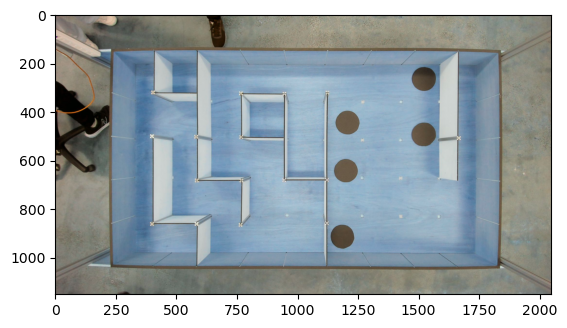

[[ 1.00000000e+00 -1.05471187e-15 -2.30000000e+02]
 [-6.24500451e-16  9.71910112e-01 -1.45786517e+02]
 [-1.13841228e-18 -1.45012041e-18  1.00000000e+00]]


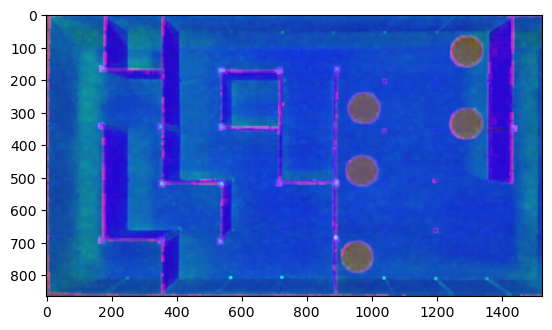

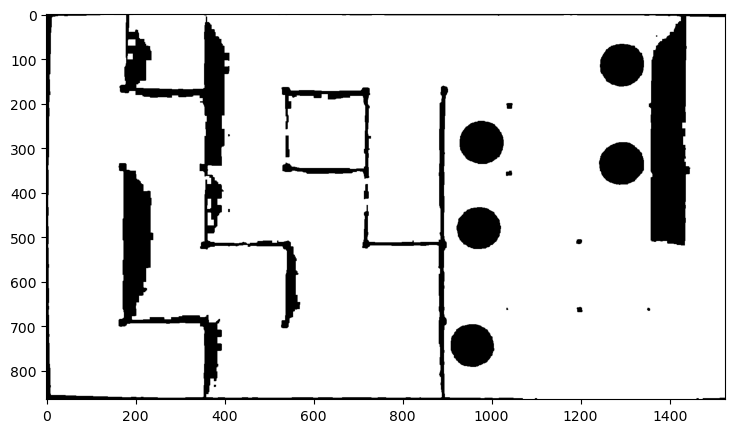

In [3]:
img = cv2.imread('maze_r3.jpg') # TODO: Replace with code to load the image
imgHSV = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
plt.imshow(img)
plt.show()
# pts1 = np.float32([[215,125],[1740,125],[215,990],[1740,990]]) # four points on the first image
pts1 = np.float32([[230,150],[1800,150],[230,1040],[1800,1040]]) # four points on the first image

# pts2 = np.float32([[0,0],[1525,0],[0,865],[1525,865]]) # four points on the second image
pts2 = np.float32([[0,0],[1570,0],[0,865],[1570,865]]) # four points on the second image

H = cv2.getPerspectiveTransform(pts1,pts2) # homography matrix
print(H)
cropped_image = cv2.warpPerspective(imgHSV, H, (1525,865))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

cropped_image = cv2.dilate(cropped_image,kernel,iterations=4)

plt.imshow(cropped_image)
plt.show()




# imgHSVMasked = cv2.inRange(cropped_image,(6,45,98),(87,255,237))
imgHSVMasked = cv2.inRange(cropped_image,(33,0,0),(178,255,255))

imgHSVFinal = imgHSVMasked.copy()
imgHSVFinal = cv2.cvtColor(imgHSVFinal, cv2.COLOR_GRAY2RGB)  # Convert single channel to BGR
imgHSVFinal = cv2.erode(imgHSVFinal, kernel, iterations=3)
inverted_image = cv2.bitwise_not(imgHSVFinal)
# inverted_image = cv2.dilate(inverted_image, kernel, iterations=2)
plt.figure(figsize = (9,5))
plt.imshow(inverted_image)

plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]


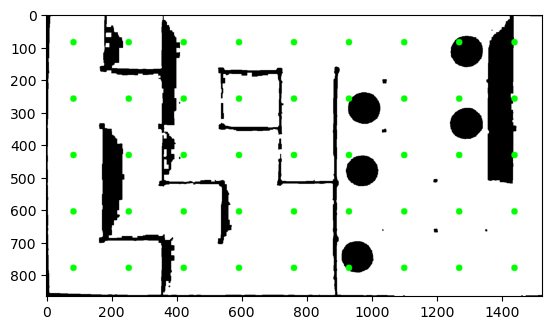

In [4]:
bfs_image = inverted_image.copy()
bfs_graph = Graph()

height,width,_ = bfs_image.shape
x_step = width/(9)
y_step = height/(5)

# bfs_image = cv2.circle(bfs_image,(300,200),10,(0,255,0),-1)
# bfs_image = cv2.circle(bfs_image,(550,200),10,(0,255,0),-1)

node_id = 0
for row in range(5):
    for col in range(9):
        x = ((col+0.5)*x_step)
        y = ((row+0.5)*y_step)
        bfs_graph.add_node((node_id),x,y)
        bfs_image = cv2.circle(bfs_image,(int(x),int(y)),10,(0,255,0),-1)
        node_id += 1
nodes_list = bfs_graph.get_nodes()
print(nodes_list)
plt.imshow(bfs_image,cmap='gray')
plt.show()

In [5]:
def path_clear(image, x1, y1, x2, y2):
    clear = True
    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)
    x = abs(x2-x1)
    y = abs(y2-y1)

    # if the nodes are vertical (same x axis, different y values)
    # should be equal to 0, but in case there are rounding discrepancies in coordinate values
    if x == 0:
        for i in range(y):
            # if there is an red or black obstacle, return false
            if( image[y2+i,x1] == [0,0,0]).all():
                clear = False
    
    # if the nodes are horizontal (same y axis, different x values)
    else:
        for i in range(x):

            if (image[y1][x2+i] == [0,0,0]).all():
                clear = False    
    return clear

def is_close(x1, x2, tol=1.0):
    return abs(x1 - x2) <= tol


def calculate_weighting(node_id1, node_id2):
    x1,y1 = bfs_graph.nodes[node_id1].get_point()
    x2,y2 = bfs_graph.nodes[node_id2].get_point()
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)




173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0
173.0


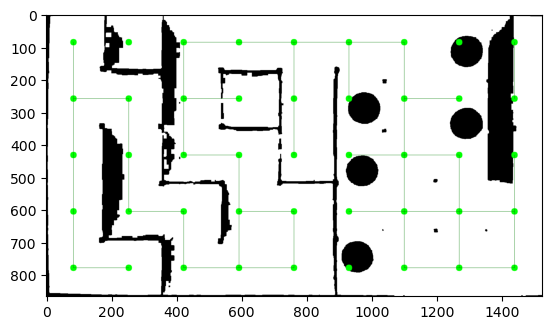

In [6]:
i = 0
for col in range(9):
    for row in range(5):
        node_id1 = col*5 + row

        x1,y1 = bfs_graph.nodes[node_id1].get_point()
        x_left = x1-x_step
        y_left = y1
        x_up = x1
        y_up = y1-y_step

        # Check for available node to the left of current node
        if path_clear(bfs_image, x1,y1,x_left,y_left):
            # draw line between connecting nodes
            cv2.line(bfs_image, (int(x1),int(y1)), (int(x_left),int(y_left)), (0,125,0),1)
            node_id2 = 0
            for n in range(node_id-1):
                # Check if the current point matches a point of a node, if so, that is node 2 
                # (used to find index of node 2 to then create an edge)
                if (is_close(bfs_graph.nodes[n].get_point()[0], x_left)) and (is_close(bfs_graph.nodes[n].get_point()[1], y_left)):
                    node_id2 = n
                    weight = calculate_weighting(node_id1, node_id2)
                    bfs_graph.add_edge(node_id1, node_id2, weight)

        # Check for available node above current node
        if path_clear(bfs_image, x1,y1,x_up,y_up):
            cv2.line(bfs_image, (int(x1),int(y1)), (int(x_up),int(y_up)), (0,125,0),1)
            node_id2 = 0
            # Check if the current point matches a point of a node, if so, that is node 2
            for m in range(node_id-1):
                if (is_close(bfs_graph.nodes[m].get_point()[0], x_up)) and (is_close(bfs_graph.nodes[m].get_point()[1], y_up)):
                        node_id2 = m
                        weight = calculate_weighting(node_id1, node_id2)
                        print(weight)
                        bfs_graph.add_edge(node_id1, node_id2, weight)
                           
plt.imshow(bfs_image)
plt.show()

Path: [0, 9, 10, 19, 28, 29, 38, 39, 30, 21, 20, 11, 2, 3, 4, 5, 6, 15, 24, 33, 42, 43, 44]


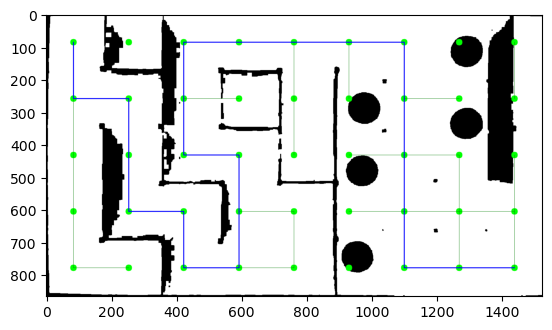

In [7]:
def bfs(graph, start_node_id, end_node_id):
    queue = deque([start_node_id])
    visited = set()
    path = []
    parents = {start_node_id: None}
    
    while queue:
        current_node_id = queue.popleft()
        
        # skip this node if we have already visited it
        if current_node_id in visited:
            continue
        
        # if we haven't visited it: 
        visited.add(current_node_id)
#         path.append(current_node_id)
        
        # We have found the end of the path
        if current_node_id == end_node_id:
            while current_node_id is not None:
                path.append(current_node_id)
                current_node_id = parents[current_node_id]
            path.reverse()
            return path
        
        # reverse the order of the neighbours to match spec (both give a valid path, reversed or not)
        neighbours = bfs_graph.get_neighbours(current_node_id)
        neighbours.reverse()
#         find neighbours that share common edges and add to queue
        for neighbour_id in neighbours:
            if neighbour_id not in visited and neighbour_id not in queue:
                queue.append(neighbour_id)
                parents[neighbour_id] = current_node_id
        
            
    return path
# Task 3.2: Impliment BFS continued

# Run bfs and display the output
path = bfs(bfs_graph,0,44)

length = len(path)
for i in range(length-1):
    x1,y1 = bfs_graph.nodes[path[i]].get_point()
    x2,y2 = bfs_graph.nodes[path[i+1]].get_point()
    
    cv2.line(bfs_image, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255),2)



# Display resulting image
print(f"Path: {path}")
plt.imshow(bfs_image)
plt.show()

In [8]:
def find_direction(graph, path):
    # north is index 0, east 1, south 2, west 3
    # right 0, left 1, up 2, down 3

    lookup_normal = [
    ["rf", "lf", "f", " error "], #north
    ["f", " error ", "lf", "rf"], #east
    ["lf", "rf", " error ", "f"], #south
    [" error ", "f", "rf", "lf"]  #west
    ]

    lookup_short = [
    ["rh", "lh", "h", " error "], #north
    ["h", " error ", "lh", "rh"], #east
    ["lh", "rh", " error ", "h"], #south
    [" error ", "h", "rh", "lh"]  #west
    ]

    commands = "f"
    heading = 0
    
    if graph.nodes[path[1]].x > graph.nodes[path[0]].x:
        heading = 1 #east
    elif graph.nodes[path[1]].x < graph.nodes[path[0]].x:
        heading = 3 #west
    elif graph.nodes[path[1]].y < graph.nodes[path[0]].y:
        heading = 0 #north
    elif graph.nodes[path[1]].y > graph.nodes[path[0]].y:
        heading = 2 #south

        #print("starting heading", heading)

    for i in range(1, len(path) - 1):
        #print(heading)
        if graph.nodes[path[i+1]].x > graph.nodes[path[i]].x: #east
            if graph.edges[path[i]][path[i+1]] > 160:
                commands += lookup_normal[heading][0]
            else:
                commands += lookup_short[heading][0]
            heading = 1
            #print("east")
        elif graph.nodes[path[i+1]].x < graph.nodes[path[i]].x: #west
            if graph.edges[path[i]][path[i+1]] > 160:
                commands += lookup_normal[heading][1]
            else:
                commands += lookup_short[heading][1]
            heading = 3
            #print("west")
        elif graph.nodes[path[i+1]].y < graph.nodes[path[i]].y: #north
            if graph.edges[path[i]][path[i+1]] > 160:
                commands += lookup_normal[heading][2]
            else:
                commands += lookup_short[heading][2]
            heading = 0
            #print("north")
        elif graph.nodes[path[i+1]].y > graph.nodes[path[i]].y: #south
            if graph.edges[path[i]][path[i+1]] > 160:
                commands += lookup_normal[heading][3]
            else:
                commands += lookup_short[heading][3]
            heading = 2
            #print("south")
    return commands
print(find_direction(bfs_graph,path))

flfrfflfrflflfflfrffrffffrfffflff
